In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from models.models import ObjectDetectionModel

In [2]:
# Custom dataset class for Moving MNIST
class MovingMNISTDataset(Dataset):
    def __init__(self, num_samples, seq_length, image_size):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.image_size = image_size
        self.data = self.generate_dataset()

    def generate_dataset(self):
        data = []
        for _ in range(self.num_samples):
            sample = []
            for _ in range(self.seq_length):
                mnist_image = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
                x, y = random.randint(0, self.image_size - 28), random.randint(0, self.image_size - 28)
                mnist_image[x:x+28, y:y+28] = np.random.randint(0, 256, size=(28, 28))
                sample.append(mnist_image)
            data.append(sample)
        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

In [3]:
# Create datasets and data loaders
train_dataset = MovingMNISTDataset(num_samples=10000, seq_length=5, image_size=64)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = ObjectDetectionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_loader:
        # Flatten the sequence and batch dimensions
        batch_size, seq_length, height, width = batch.size()
        batch = batch.view(batch_size * seq_length, 1, height, width)  

        optimizer.zero_grad()
        outputs = model(batch)
        targets = torch.zeros_like(outputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/(len(train_loader) * seq_length)}")


/tmp/ipykernel_3903086/1864378913.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(self.data[idx], dtype=torch.float32)


Epoch 1/10, Loss: 0.12131493456777004
Epoch 2/10, Loss: 2.88445002378623e-05
Epoch 3/10, Loss: 1.6582936362161712e-05
Epoch 4/10, Loss: 1.0079563817618842e-05
Epoch 5/10, Loss: 5.732984501281961e-06
Epoch 6/10, Loss: 3.1663622875078017e-06
Epoch 7/10, Loss: 1.8411256292707712e-06
Epoch 8/10, Loss: 1.154889306832093e-06
Epoch 9/10, Loss: 7.677704618967904e-07
Epoch 10/10, Loss: 5.325727469119029e-07


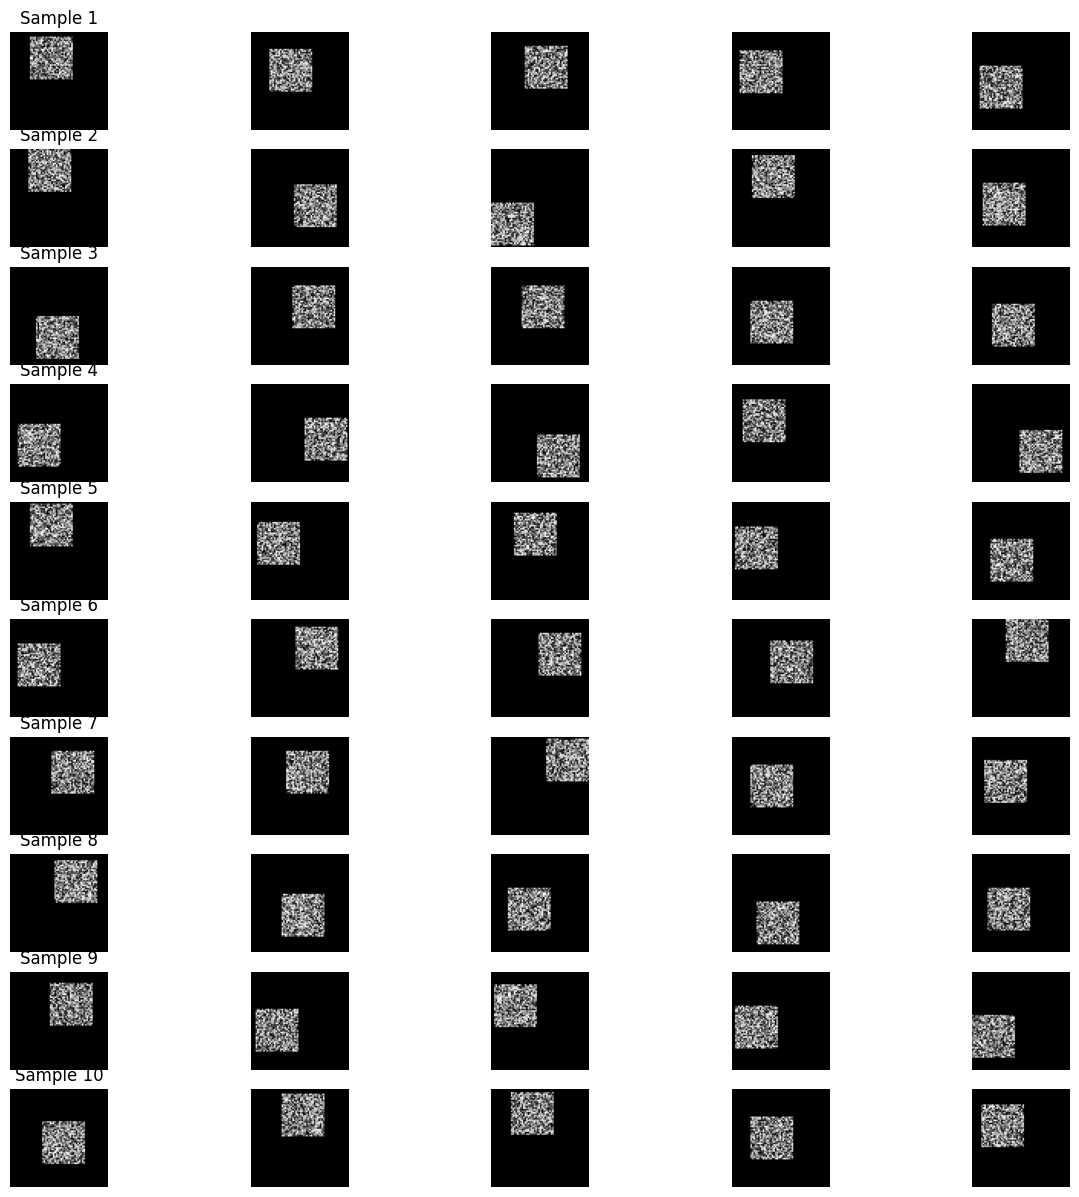

In [9]:
def show_images_and_return_labels(dataset, num_samples=10):
    selected_indices = np.random.choice(len(dataset), num_samples, replace=False)
    selected_samples = [dataset[idx] for idx in selected_indices]

    fig, axs = plt.subplots(num_samples, 5, figsize=(15, 15))

    labels = []
    for i, sample in enumerate(selected_samples):
        for j, frame in enumerate(sample):
            axs[i, j].imshow(frame.numpy(), cmap='gray')
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(f"Sample {i+1}")
            labels.append(frame)

    plt.show()

    return labels


test_dataset = MovingMNISTDataset(num_samples=1000, seq_length=5, image_size=64)

_ = show_images_and_return_labels(test_dataset)